In [17]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU!")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import math
import statistics
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=30)
mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)
    
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGE_ID = "Final_Images"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Images", IMAGE_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', DeprecationWarning)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU!


In [18]:
dataset = pd.read_csv('./Prediction/Final.csv')
dataset['Age'] = pd.to_numeric(dataset['Age']) 
dataset.head()

,Age,d180,d180N,L*,SST,Alkane,Alkanol,Sediment,Red,Green,Blue,Grey
0,0,3.228,1.161664,-2.175118,0.545283,-0.109360,-2.748250,2.729549,-0.888887,-1.393378,-1.529918,-1.261629
1,1,3.228,1.161664,-2.252229,0.152172,-0.132815,0.741463,2.729549,-0.524649,-1.095312,-1.330603,-0.954727
2,2,3.179,1.259892,-2.269439,-0.528866,0.155576,3.962484,2.729549,-0.312894,-0.918423,-1.228388,-0.773885
3,3,3.286,1.045395,-2.469090,-1.572280,0.638307,6.194622,2.729549,-0.375493,-1.005194,-1.279251,-0.850825
4,4,3.295,1.027353,-2.375546,-2.041553,1.278914,6.465403,2.729549,-0.379937,-0.992837,-1.268917,-0.844385


In [19]:
dataset.isna().sum()

Age            0
d180           0
d180N          0
L*             0
SST          158
Alkane       158
Alkanol      161
Sediment     158
Red         1395
Green       1395
Blue        1395
Grey        1395
dtype: int64

In [20]:
dataset.interpolate(method='linear', limit_direction='both', downcast='infer', axis=1, inplace=True)

In [21]:
dataset.isna().sum()

Age         0
d180        0
d180N       0
L*          0
SST         0
Alkane      0
Alkanol     0
Sediment    0
Red         0
Green       0
Blue        0
Grey        0
dtype: int64

In [22]:
dataset.tail()

,Age,d180,d180N,L*,SST,Alkane,Alkanol,Sediment,Red,Green,Blue,Grey
1898,4240.0,2.975,1.668840,1.513896,1.513896,1.513896,1.513896,1.513896,1.513896,1.513896,1.513896,1.513896
1899,4245.0,3.028,1.562594,1.327339,1.327339,1.327339,1.327339,1.327339,1.327339,1.327339,1.327339,1.327339
1900,4250.0,3.000,1.618724,1.423973,1.423973,1.423973,1.423973,1.423973,1.423973,1.423973,1.423973,1.423973
1901,4255.0,3.129,1.360124,1.069771,1.069771,1.069771,1.069771,1.069771,1.069771,1.069771,1.069771,1.069771
1902,4260.0,2.919,1.781100,1.331042,1.331042,1.331042,1.331042,1.331042,1.331042,1.331042,1.331042,1.331042


In [23]:
dataset.describe()

,Age,d180,d180N,L*,SST,Alkane,Alkanol,Sediment,Red,Green,Blue,Grey
count,1903.000000,1903.000000,1.903000e+03,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000,1903.000000
mean,1534.177614,3.807486,1.366267e-11,-0.290495,-0.263995,0.285593,0.396720,0.259381,-0.010393,-0.012474,-0.013390,-0.011902
std,1176.593587,0.498841,1.000000e+00,1.001075,1.118354,0.992439,1.006507,1.159213,0.762705,0.759320,0.758680,0.760404
min,0.000000,2.775000,-2.560963e+00,-2.902871,-2.494080,-1.439872,-2.748250,-2.025494,-3.238145,-3.037077,-2.752926,-3.075705
25%,475.500000,3.426000,-7.267121e-01,-1.059356,-1.436499,-0.282659,0.087026,-0.451596,-0.544306,-0.555393,-0.563745,-0.556886
50%,1302.000000,3.783000,4.908591e-02,-0.112870,0.358123,-0.034212,0.233629,-0.030568,-0.131698,-0.129671,-0.150062,-0.131698
75%,2441.500000,4.170000,7.647445e-01,0.501482,0.707186,0.830663,0.850636,0.681296,0.648383,0.643999,0.637084,0.640539
max,4260.000000,5.085000,2.069769e+00,1.585409,1.585409,5.710774,6.465403,4.233408,1.585409,1.585409,1.586844,1.585409


In [24]:
dataset.shape

(1903, 12)

In [25]:
X = dataset.drop(['d180', 'd180N'], axis=1)
y = dataset['d180N']

(X.shape, y.shape)

((1903, 10), (1903,))

In [26]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1712, 10) (1712,)
(191, 10) (191,)


In [27]:
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

In [28]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1712, 10) (1712,)
(191, 10) (191,)


## Building our network


Because so few samples are available, we will be using a very small network with two 
hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using 
a small network is one way to mitigate overfitting.

In [29]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Some memory clean-up
K.clear_session()

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [30]:
build_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


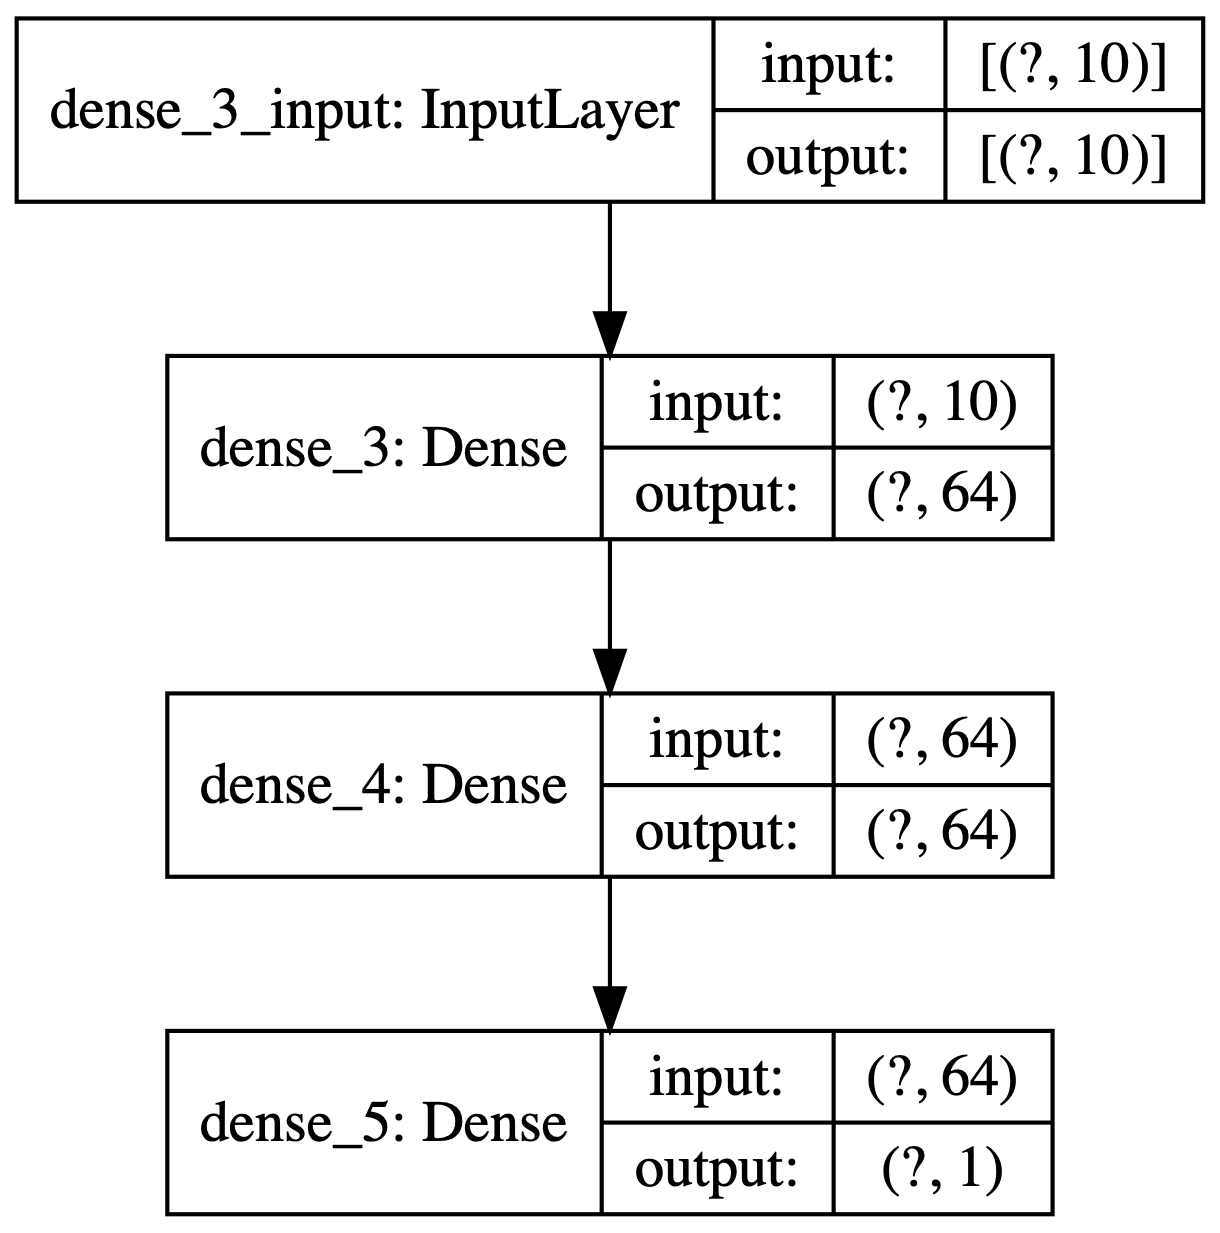

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(build_model(), to_file='./Images/Final_Images/dnn_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', dpi=300)


Our network ends with a single unit, and no activation (i.e. it will be linear layer). 
This is a typical setup for scalar regression (i.e. regression where we are trying to predict a single continuous value). 
Applying an activation function would constrain the range that the output can take; for instance if 
we applied a `sigmoid` activation function to our last layer, the network could only learn to predict values between 0 and 1. Here, because 
the last layer is purely linear, the network is free to learn to predict values in any range.

Note that we are compiling the network with the `mse` loss function -- Mean Squared Error, the square of the difference between the 
predictions and the targets, a widely used loss function for regression problems.

We are also monitoring a new metric during training: `mae`. This stands for Mean Absolute Error. It is simply the absolute value of the 
difference between the predictions and the targets. For instance, a MAE of 0.5 on this problem would mean that our predictions are off by 0.5 (ng/g) on average.

## Validating our approach using K-fold validation


To evaluate our network while we keep adjusting its parameters (such as the number of epochs used for training), we could simply split the 
data into a training set and a validation set, as we were doing in our previous examples. However, because we have so few data points, the 
validation set would end up being very small (e.g. about 100 examples). A consequence is that our validation scores may change a lot 
depending on _which_ data points we choose to use for validation and which we choose for training, i.e. the validation scores may have a 
high _variance_ with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions 
(typically K=4 or 5), then instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining 
partition. The validation score for the model used would then be the average of the K validation scores obtained.

In [32]:
# Some memory clean-up
K.clear_session()

k = 4
num_val_samples = len(X_train) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model0 = build_model()
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    # Train the model
    history0 = model0.fit(partial_train_data, partial_train_targets,
                         validation_data=(val_data, val_targets),
                         epochs=num_epochs, batch_size=10,
                         callbacks=[es])
    # Evaluate the model on the validation data
    val_mse, val_mae = model0.evaluate(val_data, val_targets)
    all_scores.append(val_mae)

processing fold # 0
Train on 1284 samples, validate on 428 samples
Epoch 1/100
1284/1284 [==============================] - 1s 655us/sample - loss: 2529.2305 - mae: 14.2132 - val_loss: 0.7580 - val_mae: 0.7037
Epoch 2/100
1284/1284 [==============================] - 0s 159us/sample - loss: 582.0733 - mae: 12.0222 - val_loss: 2.2051 - val_mae: 1.1704
Epoch 3/100
1284/1284 [==============================] - 0s 159us/sample - loss: 460.9172 - mae: 10.2177 - val_loss: 240.5268 - val_mae: 12.1550
Epoch 4/100
1284/1284 [==============================] - 0s 159us/sample - loss: 426.9792 - mae: 9.5639 - val_loss: 8.3776 - val_mae: 2.2294
Epoch 5/100
1284/1284 [==============================] - 0s 161us/sample - loss: 419.0064 - mae: 9.6903 - val_loss: 301.4868 - val_mae: 14.0459
Epoch 6/100
1284/1284 [==============================] - 0s 160us/sample - loss: 281.1451 - mae: 7.3763 - val_loss: 4.6062 - val_mae: 1.8866
Epoch 7/100
1284/1284 [==============================] - 0s 156us/sample - lo

processing fold # 1
Train on 1284 samples, validate on 428 samples
Epoch 1/100
1284/1284 [==============================] - 1s 590us/sample - loss: 665.0734 - mae: 13.5492 - val_loss: 1.2260 - val_mae: 0.9109
Epoch 2/100
1284/1284 [==============================] - 0s 159us/sample - loss: 486.5164 - mae: 8.2666 - val_loss: 7.3517 - val_mae: 2.3554
Epoch 3/100
1284/1284 [==============================] - 0s 163us/sample - loss: 452.7176 - mae: 12.0536 - val_loss: 2.9748 - val_mae: 1.3325
Epoch 4/100
1284/1284 [==============================] - 0s 157us/sample - loss: 360.4656 - mae: 9.1648 - val_loss: 4.6322 - val_mae: 1.6308
Epoch 5/100
1284/1284 [==============================] - 0s 160us/sample - loss: 285.3118 - mae: 8.9032 - val_loss: 1624.9135 - val_mae: 31.2342
Epoch 6/100
1284/1284 [==============================] - 0s 161us/sample - loss: 260.5166 - mae: 8.2271 - val_loss: 34.1459 - val_mae: 4.6679
Epoch 7/100
1284/1284 [==============================] - 0s 163us/sample - loss:

processing fold # 2
Train on 1284 samples, validate on 428 samples
Epoch 1/100
1284/1284 [==============================] - 1s 650us/sample - loss: 460.3836 - mae: 7.6189 - val_loss: 1.3541 - val_mae: 0.9434
Epoch 2/100
1284/1284 [==============================] - 0s 169us/sample - loss: 163.8063 - mae: 5.7335 - val_loss: 654.6957 - val_mae: 20.0629
Epoch 3/100
1284/1284 [==============================] - 0s 173us/sample - loss: 155.3579 - mae: 6.0806 - val_loss: 11.3842 - val_mae: 2.5525
Epoch 4/100
1284/1284 [==============================] - 0s 168us/sample - loss: 133.2434 - mae: 4.6367 - val_loss: 0.9837 - val_mae: 0.7909
Epoch 5/100
1284/1284 [==============================] - 0s 167us/sample - loss: 115.9733 - mae: 5.1955 - val_loss: 244.2837 - val_mae: 12.4763
Epoch 6/100
1284/1284 [==============================] - 0s 164us/sample - loss: 107.0566 - mae: 4.1968 - val_loss: 868.1636 - val_mae: 23.2249
Epoch 7/100
1284/1284 [==============================] - 0s 178us/sample - lo

Epoch 59/100
1284/1284 [==============================] - 0s 162us/sample - loss: 0.3107 - mae: 0.4307 - val_loss: 0.2259 - val_mae: 0.3759
Epoch 60/100
1284/1284 [==============================] - 0s 161us/sample - loss: 0.2656 - mae: 0.3975 - val_loss: 0.2103 - val_mae: 0.3567
Epoch 61/100
1284/1284 [==============================] - 0s 160us/sample - loss: 0.2626 - mae: 0.3941 - val_loss: 0.2176 - val_mae: 0.3727
Epoch 62/100
1284/1284 [==============================] - 0s 155us/sample - loss: 0.2607 - mae: 0.3980 - val_loss: 0.2117 - val_mae: 0.3657
Epoch 63/100
1284/1284 [==============================] - 0s 161us/sample - loss: 0.2758 - mae: 0.4079 - val_loss: 0.2235 - val_mae: 0.3673
Epoch 64/100
1284/1284 [==============================] - 0s 158us/sample - loss: 0.2641 - mae: 0.3991 - val_loss: 0.2305 - val_mae: 0.3906
Epoch 65/100
1284/1284 [==============================] - 0s 163us/sample - loss: 0.2579 - mae: 0.3981 - val_loss: 0.2098 - val_mae: 0.3601
Epoch 66/100
1284/12

processing fold # 3
Train on 1284 samples, validate on 428 samples
Epoch 1/100
1284/1284 [==============================] - 1s 537us/sample - loss: 1821.9485 - mae: 13.2147 - val_loss: 2693.6314 - val_mae: 41.5521
Epoch 2/100
1284/1284 [==============================] - 0s 160us/sample - loss: 495.5040 - mae: 10.6961 - val_loss: 1401.8764 - val_mae: 29.9518
Epoch 3/100
1284/1284 [==============================] - 0s 164us/sample - loss: 457.4386 - mae: 10.5264 - val_loss: 0.8857 - val_mae: 0.7484
Epoch 4/100
1284/1284 [==============================] - 0s 163us/sample - loss: 365.9500 - mae: 8.2391 - val_loss: 0.6854 - val_mae: 0.6666
Epoch 5/100
1284/1284 [==============================] - 0s 161us/sample - loss: 379.1914 - mae: 9.6488 - val_loss: 0.5612 - val_mae: 0.5980
Epoch 6/100
1284/1284 [==============================] - 0s 161us/sample - loss: 307.2200 - mae: 7.7157 - val_loss: 301.6524 - val_mae: 14.1776
Epoch 7/100
1284/1284 [==============================] - 0s 158us/sample

1284/1284 [==============================] - 0s 374us/sample - loss: 2.6221 - mae: 0.9075 - val_loss: 0.2379 - val_mae: 0.3753
Epoch 59/100
1284/1284 [==============================] - 1s 444us/sample - loss: 2.2724 - mae: 0.9548 - val_loss: 0.2144 - val_mae: 0.3648
Epoch 60/100
1284/1284 [==============================] - 0s 201us/sample - loss: 1.9897 - mae: 0.8722 - val_loss: 0.2187 - val_mae: 0.3580
Epoch 61/100
1284/1284 [==============================] - 0s 171us/sample - loss: 1.8813 - mae: 0.8585 - val_loss: 0.2106 - val_mae: 0.3592
Epoch 62/100
1284/1284 [==============================] - 0s 162us/sample - loss: 2.2138 - mae: 0.8686 - val_loss: 0.2207 - val_mae: 0.3703
Epoch 63/100
1284/1284 [==============================] - 0s 185us/sample - loss: 2.3232 - mae: 0.9259 - val_loss: 0.5920 - val_mae: 0.6218
Epoch 64/100
1284/1284 [==============================] - 0s 172us/sample - loss: 2.0867 - mae: 0.8723 - val_loss: 26.1613 - val_mae: 4.1764
Epoch 65/100
1284/1284 [========

In [33]:
print(all_scores)
print(np.mean(all_scores))

[0.9759237, 0.6529618, 0.4003595, 0.8494431]
0.71967196


Saving figure 4_fold_100Epoch_MSE_Val_MSE


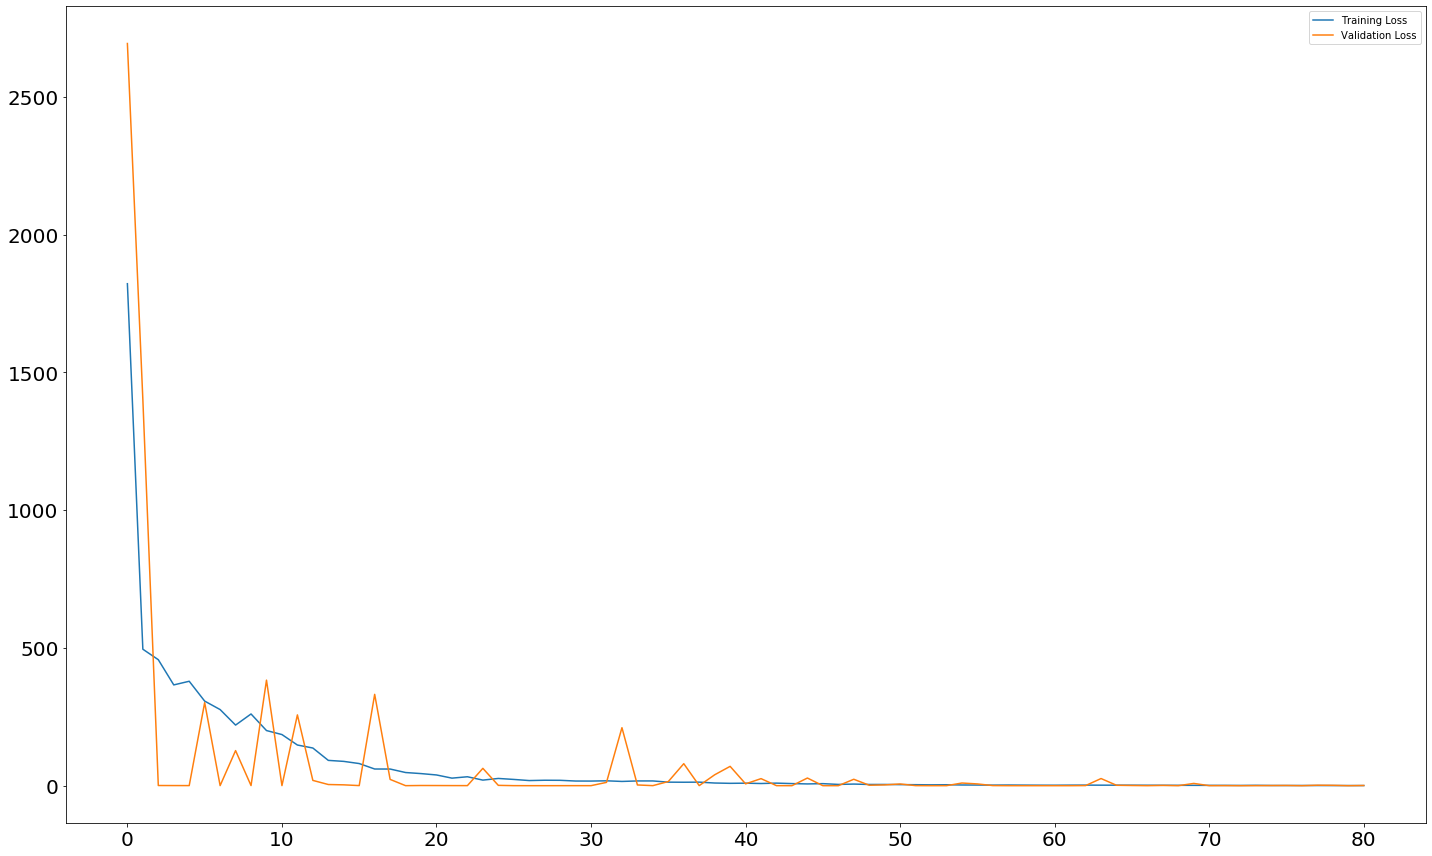

In [34]:
plt.figure(figsize=(20,12))
plt.plot(history0.history['loss'], label='Training Loss')
plt.plot(history0.history['val_loss'], label='Validation Loss')
plt.legend()
save_fig('4_fold_100Epoch_MSE_Val_MSE')

Saving figure 4_fold_100Epoch_MAE_Val_MAE


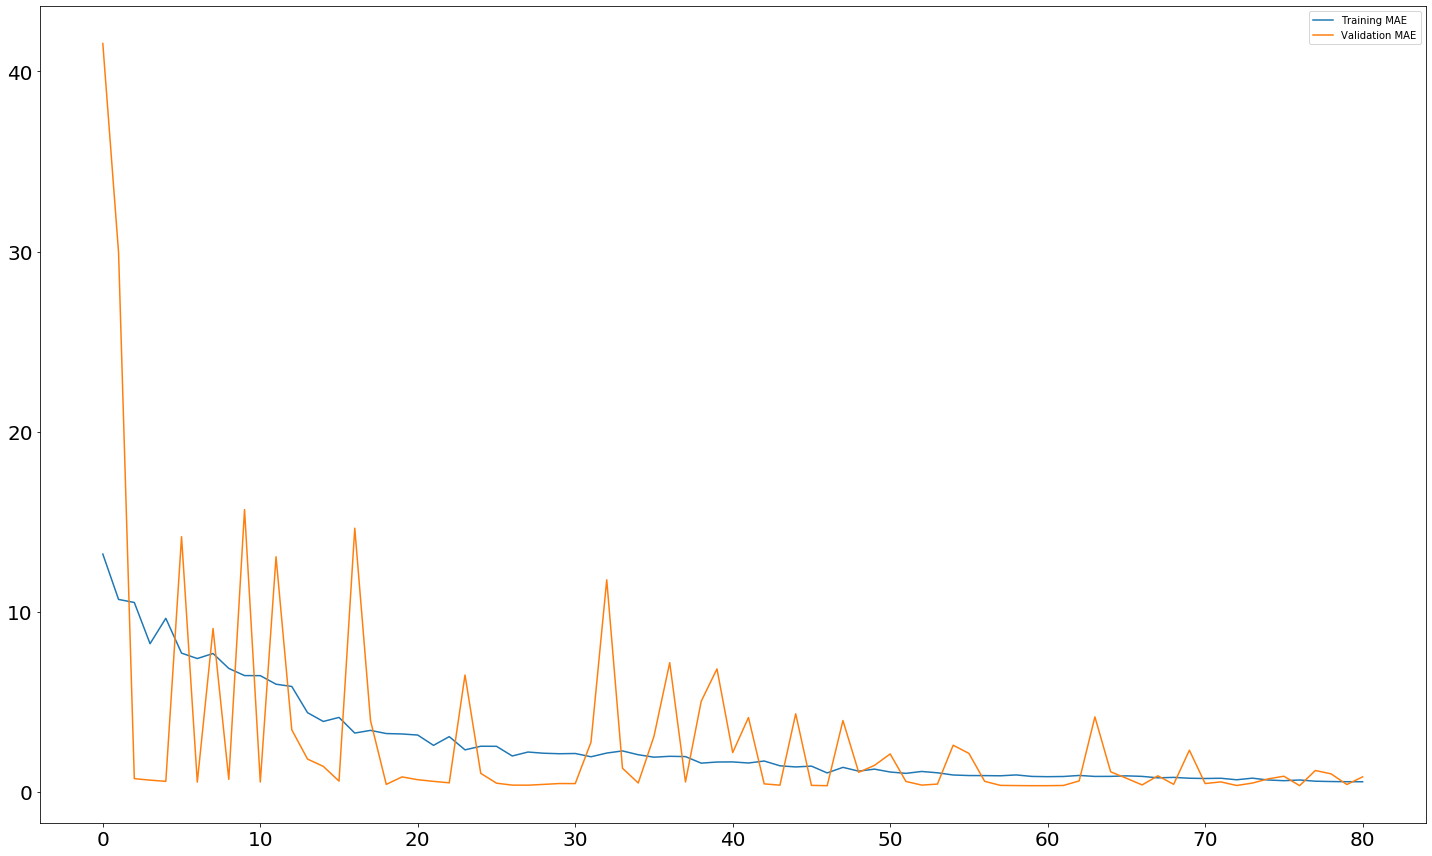

In [38]:
plt.figure(figsize=(20,12))
plt.plot(history0.history['mae'][0:], label='Training MAE')
plt.plot(history0.history['val_mae'][0:], label='Validation MAE')
plt.legend()
save_fig('4_fold_100Epoch_MAE_Val_MAE')


As you can notice, the different runs do indeed show rather different validation scores, from 0.35 to 0.37. Their average (0.357) is a much more 
reliable metric than any single of these scores -- that's the entire point of K-fold cross-validation. In this case, we are off by 0.357 on 
average, which is still significant considering that the d18O ratios range from 2.77 to 5.08. 

Let's try training the network for a bit longer: 500 epochs. To keep a record of how well the model did at each epoch, we will modify our training loop 
to save the per-epoch validation score log:

In [40]:
# Some memory clean-up
K.clear_session()

In [41]:
num_epochs = 500
all_mae_histories1 = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model1 = build_model()
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    # Train the model
    history1 = model1.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=10,
                         callbacks=[es])
    mae_history1 = history1.history['val_mae']
    all_mae_histories1.append(mae_history1)

processing fold # 0
Train on 1284 samples, validate on 428 samples
Epoch 1/500
1284/1284 [==============================] - 1s 606us/sample - loss: 1124.6593 - mae: 14.6778 - val_loss: 62.4508 - val_mae: 6.0248
Epoch 2/500
1284/1284 [==============================] - 0s 161us/sample - loss: 901.5646 - mae: 13.2431 - val_loss: 35.0314 - val_mae: 4.5242
Epoch 3/500
1284/1284 [==============================] - 0s 154us/sample - loss: 792.3065 - mae: 12.1706 - val_loss: 1.5525 - val_mae: 1.1032
Epoch 4/500
1284/1284 [==============================] - 0s 160us/sample - loss: 683.2117 - mae: 13.1779 - val_loss: 13.0427 - val_mae: 3.0989
Epoch 5/500
1284/1284 [==============================] - 0s 154us/sample - loss: 526.1507 - mae: 9.9341 - val_loss: 355.5594 - val_mae: 15.2155
Epoch 6/500
1284/1284 [==============================] - 0s 158us/sample - loss: 531.2902 - mae: 11.3546 - val_loss: 13.3778 - val_mae: 3.1136
Epoch 7/500
1284/1284 [==============================] - 0s 157us/sample -

1284/1284 [==============================] - 0s 159us/sample - loss: 2.1053 - mae: 0.9375 - val_loss: 1.1206 - val_mae: 0.9086
Epoch 59/500
1284/1284 [==============================] - 0s 158us/sample - loss: 1.8111 - mae: 0.8899 - val_loss: 0.2528 - val_mae: 0.3952
Epoch 60/500
1284/1284 [==============================] - 0s 158us/sample - loss: 1.5906 - mae: 0.8764 - val_loss: 3.9690 - val_mae: 1.6567
Epoch 61/500
1284/1284 [==============================] - 0s 157us/sample - loss: 1.3830 - mae: 0.7530 - val_loss: 0.2503 - val_mae: 0.3939
Epoch 62/500
1284/1284 [==============================] - 0s 154us/sample - loss: 1.6748 - mae: 0.8378 - val_loss: 0.2695 - val_mae: 0.4002
Epoch 63/500
1284/1284 [==============================] - 0s 160us/sample - loss: 1.2653 - mae: 0.7635 - val_loss: 1.0234 - val_mae: 0.8621
Epoch 64/500
1284/1284 [==============================] - 0s 157us/sample - loss: 1.0929 - mae: 0.7155 - val_loss: 3.4468 - val_mae: 1.5508
Epoch 65/500
1284/1284 [=========

1284/1284 [==============================] - 0s 159us/sample - loss: 18.6330 - mae: 2.4125 - val_loss: 0.8835 - val_mae: 0.7363
Epoch 26/500
1284/1284 [==============================] - 0s 160us/sample - loss: 21.2771 - mae: 2.5866 - val_loss: 0.6067 - val_mae: 0.6127
Epoch 27/500
1284/1284 [==============================] - 0s 168us/sample - loss: 20.6275 - mae: 2.4449 - val_loss: 0.3856 - val_mae: 0.5126
Epoch 28/500
1284/1284 [==============================] - 0s 155us/sample - loss: 18.7569 - mae: 2.1349 - val_loss: 0.2715 - val_mae: 0.4005
Epoch 29/500
1284/1284 [==============================] - 0s 159us/sample - loss: 16.2262 - mae: 2.0114 - val_loss: 19.3506 - val_mae: 3.4692
Epoch 30/500
1284/1284 [==============================] - 0s 158us/sample - loss: 20.3092 - mae: 2.3235 - val_loss: 0.6081 - val_mae: 0.6662
Epoch 31/500
1284/1284 [==============================] - 0s 164us/sample - loss: 16.7790 - mae: 2.4846 - val_loss: 9.6907 - val_mae: 2.4988
Epoch 32/500
1284/1284 [=

Epoch 7/500
1284/1284 [==============================] - 0s 157us/sample - loss: 230.0085 - mae: 6.8297 - val_loss: 0.6201 - val_mae: 0.6673
Epoch 8/500
1284/1284 [==============================] - 0s 163us/sample - loss: 182.4682 - mae: 5.5378 - val_loss: 19.0620 - val_mae: 3.3868
Epoch 9/500
1284/1284 [==============================] - 0s 161us/sample - loss: 177.0308 - mae: 6.5014 - val_loss: 20.5413 - val_mae: 3.7036
Epoch 10/500
1284/1284 [==============================] - 0s 157us/sample - loss: 155.7126 - mae: 5.6388 - val_loss: 13.9469 - val_mae: 3.0888
Epoch 11/500
1284/1284 [==============================] - 0s 154us/sample - loss: 142.4173 - mae: 6.0484 - val_loss: 0.5329 - val_mae: 0.6131
Epoch 12/500
1284/1284 [==============================] - 0s 156us/sample - loss: 116.8318 - mae: 5.0772 - val_loss: 324.9877 - val_mae: 14.1801
Epoch 13/500
1284/1284 [==============================] - 0s 159us/sample - loss: 115.0821 - mae: 4.9218 - val_loss: 0.4064 - val_mae: 0.5215
Epo

1284/1284 [==============================] - 0s 165us/sample - loss: 0.6750 - mae: 0.6078 - val_loss: 0.8121 - val_mae: 0.7744
Epoch 66/500
1284/1284 [==============================] - 0s 162us/sample - loss: 0.6349 - mae: 0.5852 - val_loss: 1.3090 - val_mae: 0.9032
Epoch 67/500
1284/1284 [==============================] - 0s 168us/sample - loss: 0.5861 - mae: 0.5653 - val_loss: 0.2494 - val_mae: 0.3999
Epoch 68/500
1284/1284 [==============================] - 0s 173us/sample - loss: 0.5310 - mae: 0.5466 - val_loss: 0.5360 - val_mae: 0.5827
Epoch 69/500
1284/1284 [==============================] - 0s 160us/sample - loss: 0.5518 - mae: 0.5449 - val_loss: 0.2245 - val_mae: 0.3768
Epoch 70/500
1284/1284 [==============================] - 0s 161us/sample - loss: 0.5547 - mae: 0.5363 - val_loss: 0.2074 - val_mae: 0.3595
Epoch 71/500
1284/1284 [==============================] - 0s 165us/sample - loss: 0.4770 - mae: 0.5305 - val_loss: 0.2491 - val_mae: 0.3954
Epoch 72/500
1284/1284 [=========

1284/1284 [==============================] - 0s 154us/sample - loss: 0.2271 - mae: 0.3715 - val_loss: 0.2227 - val_mae: 0.3783
Epoch 124/500
1284/1284 [==============================] - 0s 178us/sample - loss: 0.2292 - mae: 0.3721 - val_loss: 0.1998 - val_mae: 0.3447
Epoch 125/500
1284/1284 [==============================] - 0s 180us/sample - loss: 0.2333 - mae: 0.3826 - val_loss: 0.1923 - val_mae: 0.3396
Epoch 126/500
1284/1284 [==============================] - 0s 165us/sample - loss: 0.2247 - mae: 0.3695 - val_loss: 0.1948 - val_mae: 0.3374
Epoch 127/500
1284/1284 [==============================] - 0s 332us/sample - loss: 0.2523 - mae: 0.3831 - val_loss: 0.3512 - val_mae: 0.4842
Epoch 128/500
1284/1284 [==============================] - 1s 606us/sample - loss: 0.2281 - mae: 0.3729 - val_loss: 0.2077 - val_mae: 0.3629
Epoch 129/500
1284/1284 [==============================] - 0s 183us/sample - loss: 0.2364 - mae: 0.3798 - val_loss: 0.2220 - val_mae: 0.3768
Epoch 130/500
1284/1284 [==

1284/1284 [==============================] - 0s 163us/sample - loss: 0.2175 - mae: 0.3654 - val_loss: 0.2231 - val_mae: 0.3769
Epoch 182/500
1284/1284 [==============================] - 0s 166us/sample - loss: 0.2215 - mae: 0.3626 - val_loss: 0.2411 - val_mae: 0.3908
Epoch 183/500
1284/1284 [==============================] - 0s 163us/sample - loss: 0.2168 - mae: 0.3648 - val_loss: 0.3663 - val_mae: 0.5061
Epoch 184/500
1284/1284 [==============================] - 0s 169us/sample - loss: 0.2137 - mae: 0.3590 - val_loss: 0.1865 - val_mae: 0.3371
Epoch 185/500
1284/1284 [==============================] - 0s 178us/sample - loss: 0.2234 - mae: 0.3620 - val_loss: 0.2132 - val_mae: 0.3630
Epoch 00185: early stopping
processing fold # 3
Train on 1284 samples, validate on 428 samples
Epoch 1/500
1284/1284 [==============================] - 1s 574us/sample - loss: 1558.5275 - mae: 11.6675 - val_loss: 2692.9929 - val_mae: 41.5982
Epoch 2/500
1284/1284 [==============================] - 0s 165us/s

1284/1284 [==============================] - 0s 164us/sample - loss: 0.2877 - mae: 0.4153 - val_loss: 0.2655 - val_mae: 0.4171
Epoch 54/500
1284/1284 [==============================] - 0s 163us/sample - loss: 0.2930 - mae: 0.4234 - val_loss: 0.3547 - val_mae: 0.4887
Epoch 55/500
1284/1284 [==============================] - 0s 161us/sample - loss: 0.3193 - mae: 0.4293 - val_loss: 0.4143 - val_mae: 0.5301
Epoch 56/500
1284/1284 [==============================] - 0s 163us/sample - loss: 0.2711 - mae: 0.4022 - val_loss: 0.3398 - val_mae: 0.4767
Epoch 57/500
1284/1284 [==============================] - 0s 174us/sample - loss: 0.2775 - mae: 0.4156 - val_loss: 0.2473 - val_mae: 0.3851
Epoch 00057: early stopping


In [62]:
# print(all_mae_histories1)
print(np.min(all_mae_histories1[0][:500]))
print(np.min(all_mae_histories1[1][:500]))
print(np.min(all_mae_histories1[2][:500]))
print(np.min(all_mae_histories1[3][:500]))

0.37345508
0.34679833
0.32284582
0.35650197


We can then compute the average of the per-epoch MAE scores for all folds:

Saving figure 4_fold_500Epoch_MSE_Val_MSE


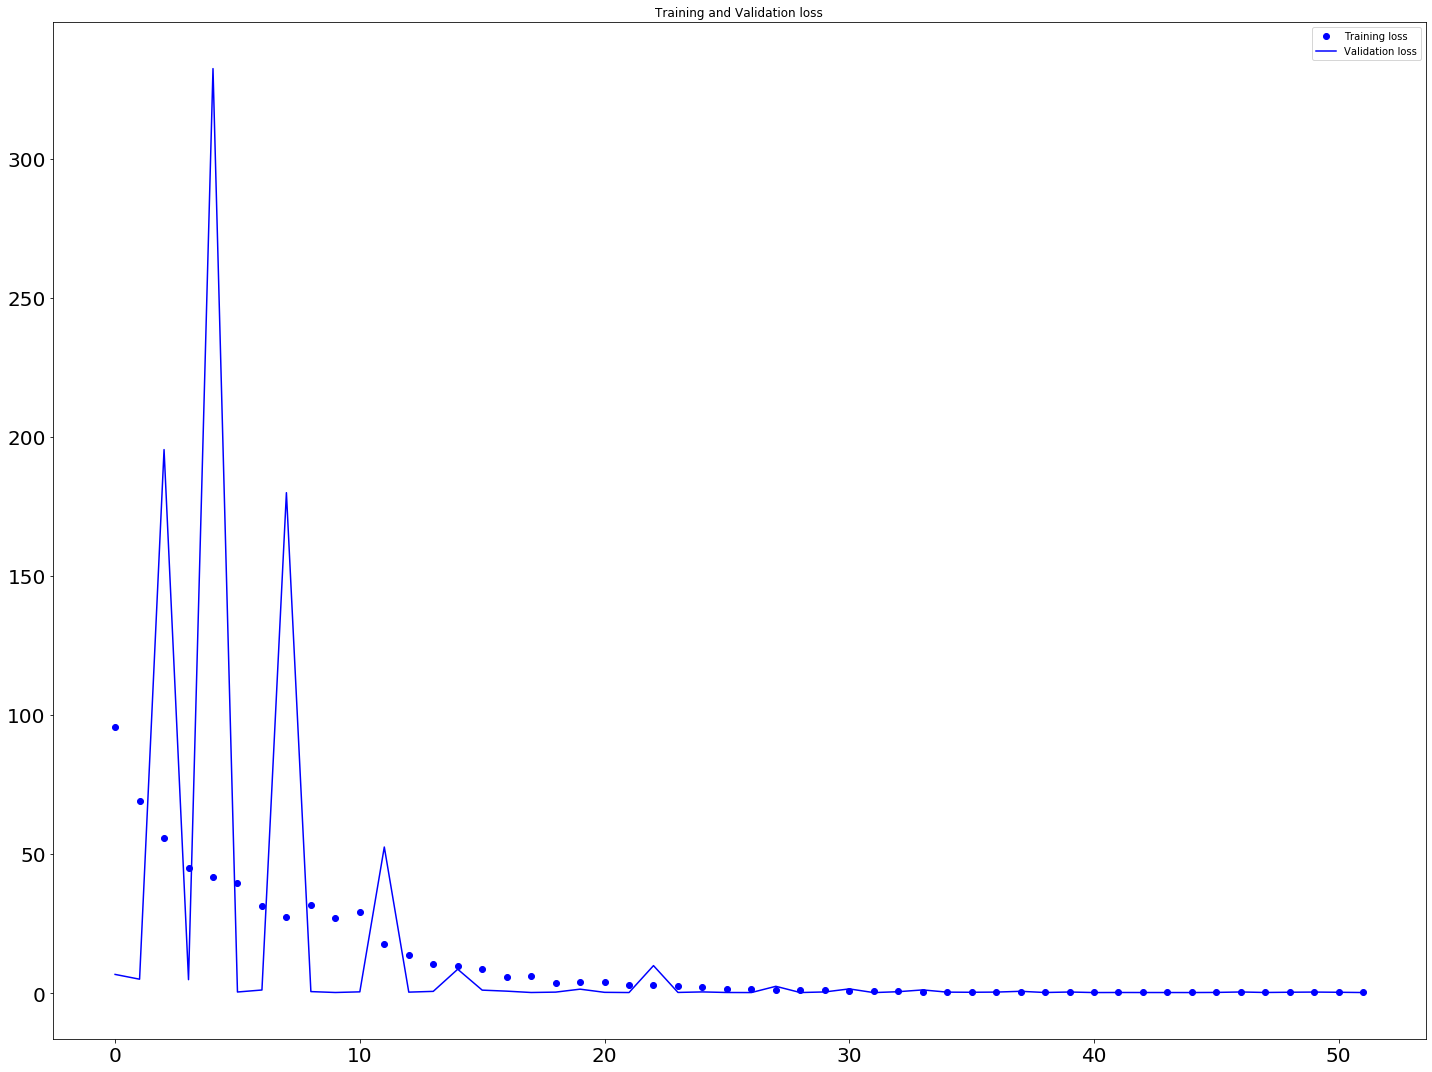

In [63]:
loss1 = history1.history['loss'][5:100]
test_loss1 = history1.history['val_loss'][5:100]

epochs = range(len(loss1))

plt.figure(figsize=(20,15))

plt.plot(epochs, loss1, 'bo', label='Training loss')
plt.plot(epochs, test_loss1, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

save_fig('4_fold_500Epoch_MSE_Val_MSE')

In [66]:
average_mae_history1 = [
    np.mean([x[i] for x in all_mae_histories1]) for i in range(num_epochs)]

IndexError: list index out of range

In [65]:
%matplotlib inline

plt.plot(range(1, len(average_mae_history1) + 1), average_mae_history1)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
save_fig('4_fold_500Epoch_MAE')

NameError: name 'average_mae_history1' is not defined


It may be a bit hard to see the plot due to scaling issues and relatively high variance. Let's:

* Omit the first 10 data points, which are on a different scale from the rest of the curve.
* Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

Saving figure smoothed_4_fold_500Epoch_MAE


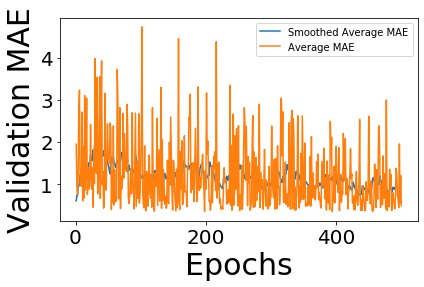

In [28]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history1 = smooth_curve(average_mae_history1[10:])

plt.plot(range(1, len(smooth_mae_history1) + 1), smooth_mae_history1, label='Smoothed Average MAE')
plt.plot(range(1, len(average_mae_history1) + 1), average_mae_history1, label='Average MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
save_fig('smoothed_4_fold_500Epoch_MAE')


According to this plot, it seems that validation MAE stops improving significantly after 80 epochs. Past that point, we start overfitting.

Once we are done tuning other parameters of our model (besides the number of epochs, we could also adjust the size of the hidden layers), we 
can train a final "production" model on all of the training data, with the best parameters, then look at its performance on the test data:

In [101]:
# Some memory clean-up
K.clear_session()

# Get a fresh, compiled model.
model2 = build_model()
# patient early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=500)
# Train it on the entirety of the data.
history2 = model2.fit(X_train, y_train,
                      shuffle='batch',
                      epochs=4000, 
                      batch_size=400,
                      callbacks=[es])

Train on 1712 samples
Epoch 1/4000
1712/1712 [==============================] - 0s 238us/sample - loss: 16631.3270 - mae: 56.3334
Epoch 2/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 35.4388 - mae: 4.6771
Epoch 3/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 168.3968 - mae: 10.0147
Epoch 4/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1094.1511 - mae: 26.0983
Epoch 5/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 2182.5659 - mae: 36.8410
Epoch 6/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 589.7111 - mae: 19.0638
Epoch 7/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 2040.1404 - mae: 35.2967
Epoch 8/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1397.7895 - mae: 29.3820
Epoch 9/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 866.5455 - mae: 23.0355
Epoch 10/4000
1712/1712 [===========

1712/1712 [==============================] - 0s 6us/sample - loss: 1318.8187 - mae: 28.5096
Epoch 79/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 669.6179 - mae: 20.4659
Epoch 80/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 605.5524 - mae: 19.1315
Epoch 81/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1308.3417 - mae: 28.6294
Epoch 82/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 893.8192 - mae: 22.9494
Epoch 83/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 364.0741 - mae: 14.9203
Epoch 84/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 1433.6985 - mae: 29.8016
Epoch 85/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 410.8455 - mae: 15.8705
Epoch 86/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 1327.9508 - mae: 28.5828
Epoch 87/4000
1712/1712 [==============================] - 0s 6us

1712/1712 [==============================] - 0s 6us/sample - loss: 453.8265 - mae: 16.8799
Epoch 156/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 477.9083 - mae: 17.2840
Epoch 157/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 440.3811 - mae: 16.5967
Epoch 158/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 615.0866 - mae: 19.5463
Epoch 159/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 209.2491 - mae: 11.3379
Epoch 160/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 763.9971 - mae: 21.8199
Epoch 161/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 272.6039 - mae: 12.9435
Epoch 162/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 659.7703 - mae: 20.2791
Epoch 163/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 438.3794 - mae: 16.4072
Epoch 164/4000
1712/1712 [==============================] - 0

1712/1712 [==============================] - 0s 6us/sample - loss: 231.9351 - mae: 11.9811
Epoch 233/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 317.0211 - mae: 14.0977
Epoch 234/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 284.4950 - mae: 13.3121
Epoch 235/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 280.2849 - mae: 13.2464
Epoch 236/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 320.2745 - mae: 14.1385
Epoch 237/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 130.3928 - mae: 8.9615
Epoch 238/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 457.2321 - mae: 16.8928
Epoch 239/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 147.9397 - mae: 9.5241
Epoch 240/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 370.8898 - mae: 15.2460
Epoch 241/4000
1712/1712 [==============================] - 0s 

1712/1712 [==============================] - 0s 6us/sample - loss: 100.7323 - mae: 7.9531
Epoch 310/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 117.8920 - mae: 8.5696
Epoch 311/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 114.8893 - mae: 8.4952
Epoch 312/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 108.6741 - mae: 8.1785
Epoch 313/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 93.4131 - mae: 7.6382
Epoch 314/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 107.5884 - mae: 8.1566
Epoch 315/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 104.1129 - mae: 8.0883
Epoch 316/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 104.8088 - mae: 8.0491
Epoch 317/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 124.5622 - mae: 8.8208
Epoch 318/4000
1712/1712 [==============================] - 0s 7us/samp

1712/1712 [==============================] - 0s 6us/sample - loss: 24.6345 - mae: 3.9489
Epoch 388/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 109.7506 - mae: 8.1727
Epoch 389/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 47.6400 - mae: 5.4810
Epoch 390/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 45.8101 - mae: 5.1973
Epoch 391/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 116.4941 - mae: 8.4404
Epoch 392/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 26.0287 - mae: 4.0267
Epoch 393/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 92.2581 - mae: 7.6024
Epoch 394/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 64.8654 - mae: 6.1999
Epoch 395/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 40.4869 - mae: 5.0319
Epoch 396/4000
1712/1712 [==============================] - 0s 6us/sample - l

1712/1712 [==============================] - 0s 6us/sample - loss: 22.7455 - mae: 3.7599
Epoch 466/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 59.5643 - mae: 6.0025
Epoch 467/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 12.1651 - mae: 2.7789
Epoch 468/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 44.2780 - mae: 5.2198
Epoch 469/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 31.9192 - mae: 4.4629
Epoch 470/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 24.9657 - mae: 3.9281
Epoch 471/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 35.5575 - mae: 4.6871
Epoch 472/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 21.7972 - mae: 3.6794
Epoch 473/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 46.3769 - mae: 5.3321
Epoch 474/4000
1712/1712 [==============================] - 0s 6us/sample - los

Epoch 544/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 15.4428 - mae: 3.1130
Epoch 545/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 25.1430 - mae: 3.9753
Epoch 546/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 15.9022 - mae: 3.1542
Epoch 547/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 12.3110 - mae: 2.7694
Epoch 548/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 31.3548 - mae: 4.3619
Epoch 549/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 10.7352 - mae: 2.5981
Epoch 550/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 20.7789 - mae: 3.5585
Epoch 551/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 14.0453 - mae: 2.9699
Epoch 552/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 46.0909 - mae: 5.0527
Epoch 553/4000
1712/1712 [==============================] - 0s 5

Epoch 623/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 17.3594 - mae: 3.2637
Epoch 624/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 7.0395 - mae: 2.1145
Epoch 625/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 14.7793 - mae: 3.0386
Epoch 626/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 13.6040 - mae: 2.8490
Epoch 627/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 6.4845 - mae: 2.0262
Epoch 628/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 20.6757 - mae: 3.5953
Epoch 629/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 5.2893 - mae: 1.8505
Epoch 630/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 13.6911 - mae: 2.8972
Epoch 631/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 9.8153 - mae: 2.4970
Epoch 632/4000
1712/1712 [==============================] - 0s 6us/s

1712/1712 [==============================] - 0s 5us/sample - loss: 8.9652 - mae: 2.3721
Epoch 703/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 14.2368 - mae: 2.9973
Epoch 704/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 8.2513 - mae: 2.2883
Epoch 705/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 11.0317 - mae: 2.6374
Epoch 706/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 11.8145 - mae: 2.7168
Epoch 707/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 10.6301 - mae: 2.6060
Epoch 708/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 10.8722 - mae: 2.6202
Epoch 709/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 7.8057 - mae: 2.2259
Epoch 710/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 16.4759 - mae: 3.1704
Epoch 711/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 

1712/1712 [==============================] - 0s 6us/sample - loss: 6.5959 - mae: 2.0513
Epoch 782/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 12.4768 - mae: 2.7269
Epoch 783/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 6.4008 - mae: 2.0331
Epoch 784/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 4.1190 - mae: 1.5933
Epoch 785/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 15.0126 - mae: 3.0477
Epoch 786/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 4.1721 - mae: 1.6330
Epoch 787/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 4.5298 - mae: 1.6603
Epoch 788/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 15.2133 - mae: 3.0187
Epoch 789/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 3.8190 - mae: 1.4534
Epoch 790/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 18.

1712/1712 [==============================] - 0s 6us/sample - loss: 6.1013 - mae: 1.9647
Epoch 861/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 7.6272 - mae: 2.2007
Epoch 862/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 4.0137 - mae: 1.6112
Epoch 863/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 7.6400 - mae: 2.1895
Epoch 864/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 2.4318 - mae: 1.2498
Epoch 865/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 8.4204 - mae: 2.3020
Epoch 866/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 4.5608 - mae: 1.7060
Epoch 867/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 3.3391 - mae: 1.4517
Epoch 868/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 8.6709 - mae: 2.3213
Epoch 869/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 3.7659

1712/1712 [==============================] - 0s 6us/sample - loss: 5.8072 - mae: 1.8303
Epoch 940/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1.5719 - mae: 1.0132
Epoch 941/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 5.9492 - mae: 1.9056
Epoch 942/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 3.2641 - mae: 1.4523
Epoch 943/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 4.2280 - mae: 1.6451
Epoch 944/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 4.0155 - mae: 1.5973
Epoch 945/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 4.2119 - mae: 1.6471
Epoch 946/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 3.0447 - mae: 1.3980
Epoch 947/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 6.1911 - mae: 1.9678
Epoch 948/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 2.6615

1712/1712 [==============================] - 0s 6us/sample - loss: 2.3801 - mae: 1.1958
Epoch 1019/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1.9919 - mae: 1.1424
Epoch 1020/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 4.1863 - mae: 1.6470
Epoch 1021/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1.5880 - mae: 1.0244
Epoch 1022/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 3.4921 - mae: 1.4822
Epoch 1023/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 2.4446 - mae: 1.2718
Epoch 1024/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 3.1246 - mae: 1.4256
Epoch 1025/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 2.9777 - mae: 1.4002
Epoch 1026/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1.8526 - mae: 1.1018
Epoch 1027/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 2.7154 - mae: 1.3263
Epoch 1097/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1.9306 - mae: 1.1293
Epoch 1098/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 2.8301 - mae: 1.3297
Epoch 1099/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 2.7323 - mae: 1.3208
Epoch 1100/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 2.0198 - mae: 1.1511
Epoch 1101/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 3.0922 - mae: 1.4142
Epoch 1102/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 1.9152 - mae: 1.1129
Epoch 1103/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 2.3049 - mae: 1.2218
Epoch 1104/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 3.7789 - mae: 1.5046
Epoch 1105/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 2.0734 - mae: 1.1650
Epoch 1175/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.8607 - mae: 0.7561
Epoch 1176/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 2.0916 - mae: 1.1593
Epoch 1177/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 2.0583 - mae: 1.1218
Epoch 1178/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.4231 - mae: 0.5299
Epoch 1179/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1.6303 - mae: 0.9880
Epoch 1180/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 2.3282 - mae: 1.1500
Epoch 1181/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.7207 - mae: 0.7007
Epoch 1182/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 2.0500 - mae: 1.1557
Epoch 1183/4000
1712/1712 [==============================] - 0s 7us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 1.5569 - mae: 1.0111
Epoch 1253/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.3140 - mae: 0.4440
Epoch 1254/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1.0175 - mae: 0.7828
Epoch 1255/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 2.0413 - mae: 1.0643
Epoch 1256/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2589 - mae: 0.4039
Epoch 1257/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1.2319 - mae: 0.8796
Epoch 1258/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1.2779 - mae: 0.8887
Epoch 1259/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.8898 - mae: 0.7671
Epoch 1260/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1.3054 - mae: 0.9308
Epoch 1261/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.5216 - mae: 0.5717
Epoch 1331/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.8146 - mae: 0.7287
Epoch 1332/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.9281 - mae: 0.7585
Epoch 1333/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.5596 - mae: 0.6144
Epoch 1334/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.7751 - mae: 0.7125
Epoch 1335/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.8743 - mae: 0.7520
Epoch 1336/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.6706 - mae: 0.6724
Epoch 1337/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 1.2844 - mae: 0.9136
Epoch 1338/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.7731 - mae: 0.6642
Epoch 1339/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.4214 - mae: 0.5213
Epoch 1409/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.6835 - mae: 0.6776
Epoch 1410/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.5531 - mae: 0.6087
Epoch 1411/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.5473 - mae: 0.6078
Epoch 1412/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.7225 - mae: 0.6880
Epoch 1413/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.4652 - mae: 0.5539
Epoch 1414/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.5505 - mae: 0.6000
Epoch 1415/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.4251 - mae: 0.5265
Epoch 1416/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.7526 - mae: 0.7055
Epoch 1417/4000
1712/1712 [==============================] - 0s 7us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.3374 - mae: 0.4609
Epoch 1487/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.6282 - mae: 0.6405
Epoch 1488/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.4925 - mae: 0.5668
Epoch 1489/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2454 - mae: 0.3902
Epoch 1490/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.7608 - mae: 0.7110
Epoch 1491/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.4065 - mae: 0.5206
Epoch 1492/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2966 - mae: 0.4340
Epoch 1493/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.3925 - mae: 0.4999
Epoch 1494/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.6754 - mae: 0.6490
Epoch 1495/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.2451 - mae: 0.3928
Epoch 1565/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.3970 - mae: 0.5045
Epoch 1566/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.4409 - mae: 0.5202
Epoch 1567/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2267 - mae: 0.3692
Epoch 1568/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.4536 - mae: 0.5473
Epoch 1569/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.4632 - mae: 0.5517
Epoch 1570/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.2504 - mae: 0.3910
Epoch 1571/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.4617 - mae: 0.5445
Epoch 1572/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.3833 - mae: 0.4968
Epoch 1573/4000
1712/1712 [==============================] - 0s 7us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.4945 - mae: 0.5655
Epoch 1643/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.2133 - mae: 0.3611
Epoch 1644/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.4335 - mae: 0.5312
Epoch 1645/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.3126 - mae: 0.4399
Epoch 1646/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2525 - mae: 0.3917
Epoch 1647/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.7960 - mae: 0.6891
Epoch 1648/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1851 - mae: 0.3307
Epoch 1649/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1749 - mae: 0.3198
Epoch 1650/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2789 - mae: 0.4091
Epoch 1651/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.3026 - mae: 0.4288
Epoch 1721/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.2851 - mae: 0.4206
Epoch 1722/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2619 - mae: 0.4018
Epoch 1723/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.4132 - mae: 0.5113
Epoch 1724/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2781 - mae: 0.4124
Epoch 1725/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1881 - mae: 0.3315
Epoch 1726/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.3971 - mae: 0.5053
Epoch 1727/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2750 - mae: 0.4154
Epoch 1728/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.3064 - mae: 0.4392
Epoch 1729/4000
1712/1712 [==============================] - 0s 7us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.2298 - mae: 0.3734
Epoch 1799/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2466 - mae: 0.3910
Epoch 1800/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2247 - mae: 0.3713
Epoch 1801/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2988 - mae: 0.4378
Epoch 1802/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2649 - mae: 0.4058
Epoch 1803/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2019 - mae: 0.3449
Epoch 1804/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.4575 - mae: 0.5370
Epoch 1805/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1849 - mae: 0.3313
Epoch 1806/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1874 - mae: 0.3337
Epoch 1807/4000
1712/1712 [==============================] - 0s 7us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.2231 - mae: 0.3684
Epoch 1877/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1835 - mae: 0.3290
Epoch 1878/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.3503 - mae: 0.4799
Epoch 1879/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.2829 - mae: 0.4038
Epoch 1880/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.3335 - mae: 0.4452
Epoch 1881/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1649 - mae: 0.3092
Epoch 1882/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1696 - mae: 0.3129
Epoch 1883/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2621 - mae: 0.4041
Epoch 1884/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2044 - mae: 0.3535
Epoch 1885/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1946 - mae: 0.3413
Epoch 1955/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2512 - mae: 0.3913
Epoch 1956/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2015 - mae: 0.3454
Epoch 1957/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2145 - mae: 0.3632
Epoch 1958/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1990 - mae: 0.3484
Epoch 1959/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2767 - mae: 0.4173
Epoch 1960/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1721 - mae: 0.3195
Epoch 1961/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2327 - mae: 0.3780
Epoch 1962/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2263 - mae: 0.3709
Epoch 1963/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.2037 - mae: 0.3491
Epoch 2033/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.4419 - mae: 0.5358
Epoch 2034/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2453 - mae: 0.3893
Epoch 2035/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2479 - mae: 0.3897
Epoch 2036/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.3355 - mae: 0.4615
Epoch 2037/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2701 - mae: 0.4141
Epoch 2038/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2405 - mae: 0.3864
Epoch 2039/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2637 - mae: 0.4094
Epoch 2040/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.3370 - mae: 0.4593
Epoch 2041/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1747 - mae: 0.3205
Epoch 2111/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1560 - mae: 0.3017
Epoch 2112/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2381 - mae: 0.3828
Epoch 2113/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1576 - mae: 0.3031
Epoch 2114/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1744 - mae: 0.3224
Epoch 2115/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1769 - mae: 0.3206
Epoch 2116/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1726 - mae: 0.3186
Epoch 2117/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1968 - mae: 0.3402
Epoch 2118/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1774 - mae: 0.3244
Epoch 2119/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1793 - mae: 0.3269
Epoch 2189/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1544 - mae: 0.2979
Epoch 2190/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.2615 - mae: 0.3982
Epoch 2191/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1528 - mae: 0.2969
Epoch 2192/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1584 - mae: 0.3022
Epoch 2193/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1516 - mae: 0.2967
Epoch 2194/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1793 - mae: 0.3255
Epoch 2195/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1764 - mae: 0.3202
Epoch 2196/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.3065 - mae: 0.4169
Epoch 2197/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1559 - mae: 0.2986
Epoch 2267/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1802 - mae: 0.3251
Epoch 2268/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1629 - mae: 0.3074
Epoch 2269/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1641 - mae: 0.3086
Epoch 2270/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1853 - mae: 0.3310
Epoch 2271/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1500 - mae: 0.2953
Epoch 2272/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1688 - mae: 0.3115
Epoch 2273/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1593 - mae: 0.3042
Epoch 2274/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1732 - mae: 0.3182
Epoch 2275/4000
1712/1712 [==============================] - 0s 7us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1697 - mae: 0.3148
Epoch 2345/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1634 - mae: 0.3096
Epoch 2346/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1659 - mae: 0.3101
Epoch 2347/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1554 - mae: 0.2985
Epoch 2348/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1793 - mae: 0.3240
Epoch 2349/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1557 - mae: 0.2996
Epoch 2350/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1592 - mae: 0.3038
Epoch 2351/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1611 - mae: 0.3075
Epoch 2352/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1529 - mae: 0.2958
Epoch 2353/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1617 - mae: 0.3071
Epoch 2423/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1524 - mae: 0.2937
Epoch 2424/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1590 - mae: 0.3032
Epoch 2425/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1766 - mae: 0.3184
Epoch 2426/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1526 - mae: 0.2937
Epoch 2427/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1475 - mae: 0.2910
Epoch 2428/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1818 - mae: 0.3307
Epoch 2429/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1493 - mae: 0.2920
Epoch 2430/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1429 - mae: 0.2842
Epoch 2431/4000
1712/1712 [==============================] - 0s 7us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1592 - mae: 0.3034
Epoch 2501/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1566 - mae: 0.2975
Epoch 2502/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1512 - mae: 0.2954
Epoch 2503/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1691 - mae: 0.3133
Epoch 2504/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1415 - mae: 0.2826
Epoch 2505/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.2241 - mae: 0.3649
Epoch 2506/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1408 - mae: 0.2847
Epoch 2507/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1404 - mae: 0.2813
Epoch 2508/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1532 - mae: 0.2950
Epoch 2509/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1502 - mae: 0.2912
Epoch 2579/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1476 - mae: 0.2909
Epoch 2580/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1829 - mae: 0.3286
Epoch 2581/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1424 - mae: 0.2853
Epoch 2582/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1692 - mae: 0.3150
Epoch 2583/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1432 - mae: 0.2867
Epoch 2584/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1483 - mae: 0.2920
Epoch 2585/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1647 - mae: 0.3098
Epoch 2586/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1588 - mae: 0.3054
Epoch 2587/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1576 - mae: 0.3024
Epoch 2657/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1552 - mae: 0.2975
Epoch 2658/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1380 - mae: 0.2796
Epoch 2659/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1649 - mae: 0.3124
Epoch 2660/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1528 - mae: 0.2986
Epoch 2661/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1434 - mae: 0.2859
Epoch 2662/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1802 - mae: 0.3261
Epoch 2663/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1383 - mae: 0.2782
Epoch 2664/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1480 - mae: 0.2884
Epoch 2665/4000
1712/1712 [==============================] - 0s 5us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1445 - mae: 0.2851
Epoch 2735/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1419 - mae: 0.2847
Epoch 2736/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1578 - mae: 0.3010
Epoch 2737/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1362 - mae: 0.2765
Epoch 2738/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1850 - mae: 0.3312
Epoch 2739/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1349 - mae: 0.2754
Epoch 2740/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1495 - mae: 0.2923
Epoch 2741/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1494 - mae: 0.2940
Epoch 2742/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1527 - mae: 0.3006
Epoch 2743/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1554 - mae: 0.3020
Epoch 2813/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1455 - mae: 0.2879
Epoch 2814/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1443 - mae: 0.2890
Epoch 2815/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1427 - mae: 0.2853
Epoch 2816/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1524 - mae: 0.2943
Epoch 2817/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1568 - mae: 0.3011
Epoch 2818/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1518 - mae: 0.2952
Epoch 2819/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1348 - mae: 0.2761
Epoch 2820/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1439 - mae: 0.2875
Epoch 2821/4000
1712/1712 [==============================] - 0s 5us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1439 - mae: 0.2895
Epoch 2891/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1580 - mae: 0.3010
Epoch 2892/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1426 - mae: 0.2849
Epoch 2893/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1503 - mae: 0.2950
Epoch 2894/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1627 - mae: 0.3057
Epoch 2895/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1346 - mae: 0.2753
Epoch 2896/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1573 - mae: 0.2999
Epoch 2897/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1459 - mae: 0.2880
Epoch 2898/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1528 - mae: 0.2986
Epoch 2899/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 7us/sample - loss: 0.1482 - mae: 0.2914
Epoch 2969/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1363 - mae: 0.2771
Epoch 2970/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1451 - mae: 0.2881
Epoch 2971/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.2074 - mae: 0.3480
Epoch 2972/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1337 - mae: 0.2748
Epoch 2973/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1347 - mae: 0.2747
Epoch 2974/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1315 - mae: 0.2739
Epoch 2975/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1553 - mae: 0.2998
Epoch 2976/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1313 - mae: 0.2708
Epoch 2977/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1279 - mae: 0.2670
Epoch 3047/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1420 - mae: 0.2830
Epoch 3048/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1506 - mae: 0.2946
Epoch 3049/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1413 - mae: 0.2853
Epoch 3050/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1567 - mae: 0.2996
Epoch 3051/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1376 - mae: 0.2788
Epoch 3052/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1644 - mae: 0.3086
Epoch 3053/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1313 - mae: 0.2720
Epoch 3054/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1359 - mae: 0.2770
Epoch 3055/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 5us/sample - loss: 0.1348 - mae: 0.2754
Epoch 3125/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1622 - mae: 0.3065
Epoch 3126/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1281 - mae: 0.2688
Epoch 3127/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1419 - mae: 0.2820
Epoch 3128/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1592 - mae: 0.3016
Epoch 3129/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1321 - mae: 0.2713
Epoch 3130/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1405 - mae: 0.2806
Epoch 3131/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1583 - mae: 0.3029
Epoch 3132/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1422 - mae: 0.2842
Epoch 3133/4000
1712/1712 [==============================] - 0s 5us/sample - los

1712/1712 [==============================] - 0s 5us/sample - loss: 0.1446 - mae: 0.2865
Epoch 3203/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1320 - mae: 0.2736
Epoch 3204/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1532 - mae: 0.2940
Epoch 3205/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1335 - mae: 0.2728
Epoch 3206/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1292 - mae: 0.2687
Epoch 3207/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1619 - mae: 0.3121
Epoch 3208/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1335 - mae: 0.2726
Epoch 3209/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1456 - mae: 0.2863
Epoch 3210/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1513 - mae: 0.2958
Epoch 3211/4000
1712/1712 [==============================] - 0s 5us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1419 - mae: 0.2856
Epoch 3281/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1493 - mae: 0.2872
Epoch 3282/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1928 - mae: 0.3357
Epoch 3283/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1362 - mae: 0.2768
Epoch 3284/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1261 - mae: 0.2671
Epoch 3285/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1313 - mae: 0.2699
Epoch 3286/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1269 - mae: 0.2667
Epoch 3287/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1285 - mae: 0.2673
Epoch 3288/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1491 - mae: 0.2905
Epoch 3289/4000
1712/1712 [==============================] - 0s 5us/sample - los

1712/1712 [==============================] - 0s 7us/sample - loss: 0.1495 - mae: 0.2919
Epoch 3359/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1337 - mae: 0.2746
Epoch 3360/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1367 - mae: 0.2779
Epoch 3361/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1314 - mae: 0.2739
Epoch 3362/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1552 - mae: 0.2975
Epoch 3363/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1432 - mae: 0.2866
Epoch 3364/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1397 - mae: 0.2793
Epoch 3365/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1422 - mae: 0.2852
Epoch 3366/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1469 - mae: 0.2898
Epoch 3367/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1315 - mae: 0.2729
Epoch 3437/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1366 - mae: 0.2805
Epoch 3438/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1424 - mae: 0.2856
Epoch 3439/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1401 - mae: 0.2824
Epoch 3440/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1276 - mae: 0.2677
Epoch 3441/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1327 - mae: 0.2715
Epoch 3442/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1433 - mae: 0.2855
Epoch 3443/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1388 - mae: 0.2816
Epoch 3444/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1356 - mae: 0.2761
Epoch 3445/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 5us/sample - loss: 0.1246 - mae: 0.2611
Epoch 3515/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1445 - mae: 0.2905
Epoch 3516/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1340 - mae: 0.2752
Epoch 3517/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1391 - mae: 0.2807
Epoch 3518/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1396 - mae: 0.2811
Epoch 3519/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1440 - mae: 0.2859
Epoch 3520/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1259 - mae: 0.2677
Epoch 3521/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1634 - mae: 0.3086
Epoch 3522/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1356 - mae: 0.2781
Epoch 3523/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1263 - mae: 0.2654
Epoch 3593/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1313 - mae: 0.2724
Epoch 3594/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1293 - mae: 0.2698
Epoch 3595/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1361 - mae: 0.2778
Epoch 3596/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1369 - mae: 0.2799
Epoch 3597/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1558 - mae: 0.3040
Epoch 3598/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1246 - mae: 0.2644
Epoch 3599/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1384 - mae: 0.2768
Epoch 3600/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1392 - mae: 0.2804
Epoch 3601/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1228 - mae: 0.2620
Epoch 3671/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1451 - mae: 0.2889
Epoch 3672/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1376 - mae: 0.2818
Epoch 3673/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1296 - mae: 0.2695
Epoch 3674/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1600 - mae: 0.3057
Epoch 3675/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1694 - mae: 0.3156
Epoch 3676/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1227 - mae: 0.2607
Epoch 3677/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1293 - mae: 0.2699
Epoch 3678/4000
1712/1712 [==============================] - 0s 7us/sample - loss: 0.1282 - mae: 0.2701
Epoch 3679/4000
1712/1712 [==============================] - 0s 7us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1346 - mae: 0.2748
Epoch 3749/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1303 - mae: 0.2736
Epoch 3750/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1289 - mae: 0.2702
Epoch 3751/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1541 - mae: 0.2985
Epoch 3752/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1357 - mae: 0.2768
Epoch 3753/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1245 - mae: 0.2628
Epoch 3754/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1354 - mae: 0.2801
Epoch 3755/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1455 - mae: 0.2885
Epoch 3756/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1289 - mae: 0.2681
Epoch 3757/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 6us/sample - loss: 0.1272 - mae: 0.2682
Epoch 3827/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1619 - mae: 0.3063
Epoch 3828/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1258 - mae: 0.2659
Epoch 3829/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1271 - mae: 0.2659
Epoch 3830/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1320 - mae: 0.2745
Epoch 3831/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1449 - mae: 0.2866
Epoch 3832/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1226 - mae: 0.2614
Epoch 3833/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1505 - mae: 0.2936
Epoch 3834/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1328 - mae: 0.2745
Epoch 3835/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 5us/sample - loss: 0.1322 - mae: 0.2718
Epoch 3905/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1279 - mae: 0.2688
Epoch 3906/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1414 - mae: 0.2861
Epoch 3907/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1355 - mae: 0.2802
Epoch 3908/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1242 - mae: 0.2624
Epoch 3909/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1461 - mae: 0.2881
Epoch 3910/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1452 - mae: 0.2873
Epoch 3911/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1358 - mae: 0.2797
Epoch 3912/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1270 - mae: 0.2682
Epoch 3913/4000
1712/1712 [==============================] - 0s 6us/sample - los

1712/1712 [==============================] - 0s 5us/sample - loss: 0.1338 - mae: 0.2776
Epoch 3983/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1431 - mae: 0.2877
Epoch 3984/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1329 - mae: 0.2758
Epoch 3985/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1260 - mae: 0.2680
Epoch 3986/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1334 - mae: 0.2767
Epoch 3987/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1291 - mae: 0.2737
Epoch 3988/4000
1712/1712 [==============================] - 0s 6us/sample - loss: 0.1794 - mae: 0.3218
Epoch 3989/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1220 - mae: 0.2620
Epoch 3990/4000
1712/1712 [==============================] - 0s 5us/sample - loss: 0.1254 - mae: 0.2659
Epoch 3991/4000
1712/1712 [==============================] - 0s 5us/sample - los

In [102]:
test_mse_score2, test_mae_score2 = model2.evaluate(X_test, y_test)

191/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [103]:
(test_mse_score2, test_mae_score2)

(0.13881794101904824, 0.26824036)

We are still off by about 0.34(ng/g).

Saving figure smoothed_4_fold_500Epoch_MAE_2


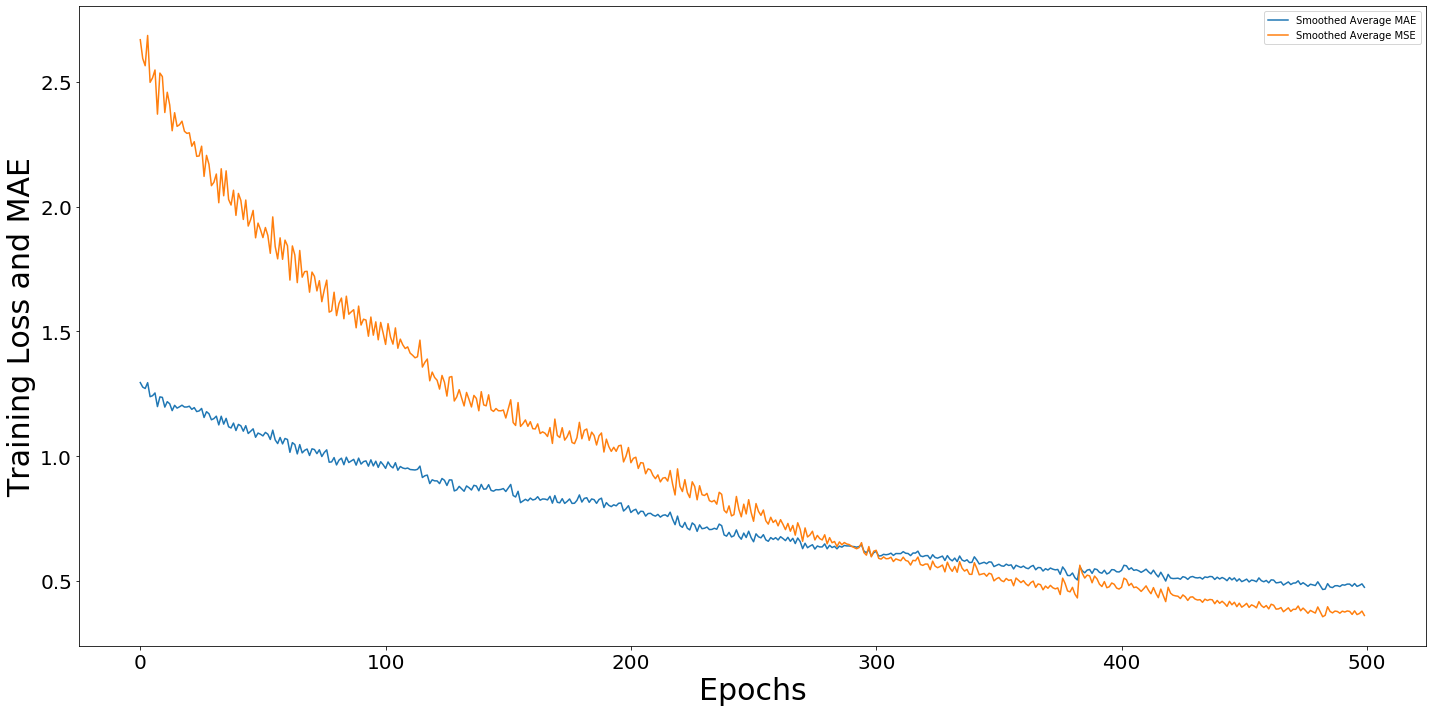

In [134]:
all_mae_histories_2 = []
mae_history_2 = history2.history['mae']
all_mae_histories_2.append(mae_history_2)

average_mae_history_2 = [
    np.mean([x[i] for x in all_mae_histories_2]) for i in range(4000)]

smooth_mae_history_2 = smooth_curve(average_mae_history_2[1000:])

all_mse_histories_2 = []
mse_history_2 = history2.history['loss']
all_mse_histories_2.append(mse_history_2)

average_mse_history_2 = [
    np.mean([x[i] for x in all_mse_histories_2]) for i in range(4000)]


smooth_mse_history_2 = smooth_curve(average_mse_history_2[1000:])

plt.figure(figsize=(20, 10))
plt.plot(smooth_mae_history_2[100:600], label='Smoothed Average MAE')
plt.plot(smooth_mse_history_2[100:600], label='Smoothed Average MSE')
# plt.plot(history2.history['mae'][1000:4000], label='MAE')
# plt.plot(history2.history['loss'][1000:4000], label='MSE')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training Loss and MAE')
save_fig('smoothed_4_fold_500Epoch_MAE_2')

Saving figure 4_fold_500Epoch_MAE_2


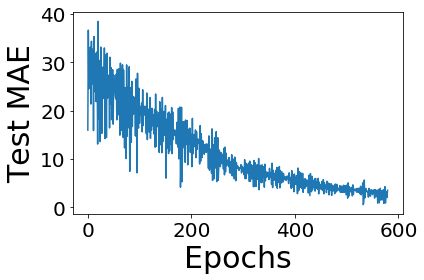

In [139]:
plt.plot(history2.history['mae'][20:600])
plt.xlabel('Epochs')
plt.ylabel('Test MAE')
save_fig('4_fold_500Epoch_MAE_2')

In [140]:
# history_test = model.evaluate(X_test, y_test)

In [141]:
preds = model2.predict(X_test)

In [155]:
true = y_test.copy()

Saving figure 10_preds_vs_true


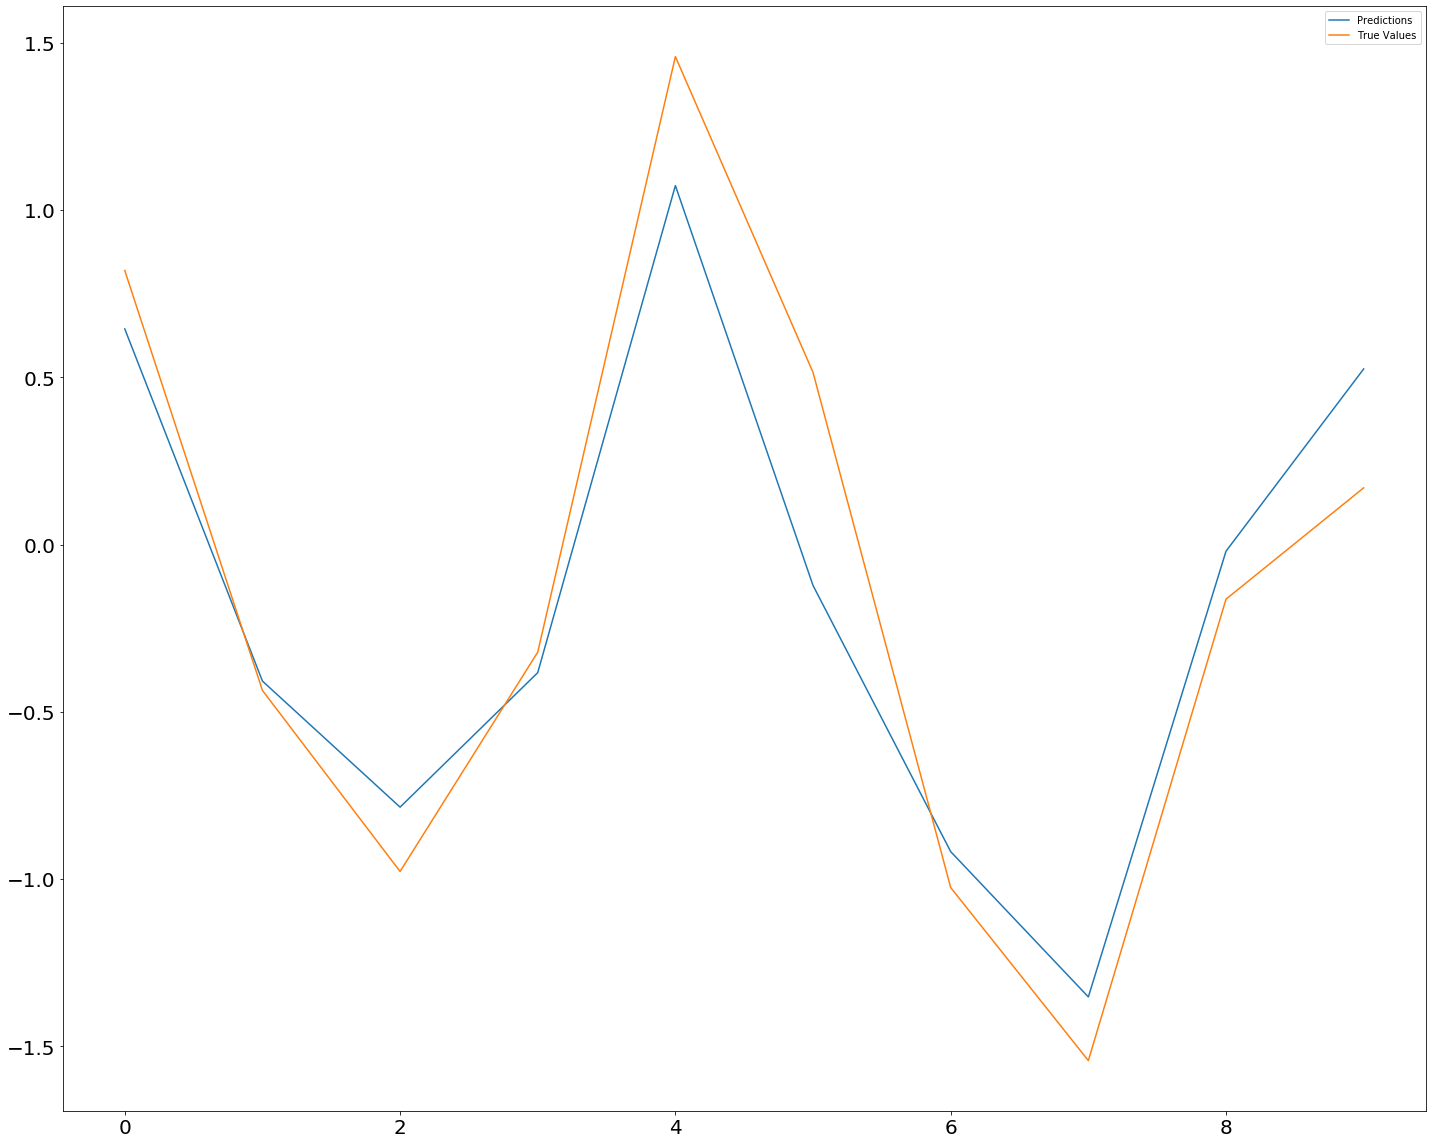

In [145]:
plt.figure(figsize=(20, 16))
plt.plot(preds[:10], label='Predictions')
plt.plot(true[:10], label='True Values')
plt.legend()
save_fig('10_preds_vs_true')

In [ ]:
plt.figure(figsize=(20, 16))
plt.plot(preds[:10], label='Predictions')
plt.plot(true[:10], label='True Values')
plt.legend()
save_fig('10_preds_vs_true')

In [ ]:
loss2 = history2.history['loss'][100:500]
mae2 = history2.history['mae'][100:500]

epochs = range(len(loss2))

plt.plot(epochs, loss2, 'bo', label='Training Loss')
plt.plot(epochs, mae2, 'b', label='Training MAE')
plt.title('Training Loss and MAE')
plt.legend()

plt.show()

d18ON
MAE:  0.26824036
RMSE:  0.13881794101904824
r2:  0.8537100907070401
Saving figure dnn_d18O_prediction


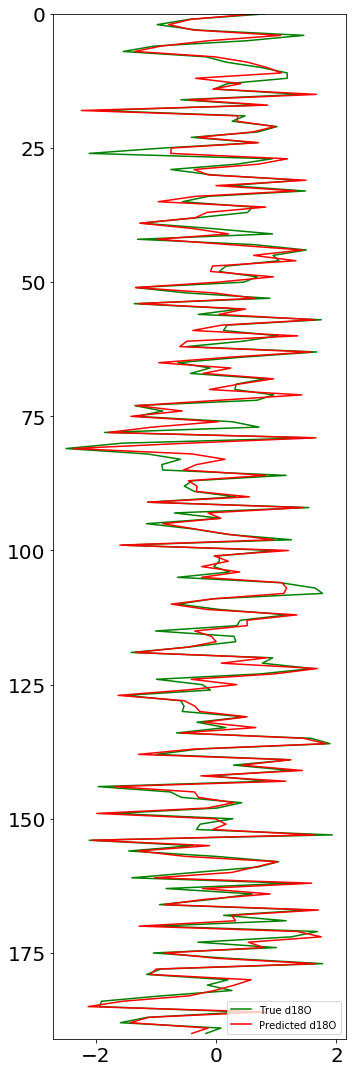

In [188]:
from sklearn.metrics import r2_score
print('d18ON')
print('MAE: ', test_mae_score2)
print('RMSE: ', test_mse_score2)
print('r2: ', r2_score(true, preds))

plt.figure(figsize=(5, 15))
plt.ylim(len(preds), 0)
plt.plot(true,range(0, len(true)), color='green', label='True d18O')
plt.plot(preds,range(0, len(preds)), color='red', label='Predicted d18O')
plt.legend()
save_fig('dnn_d18O_prediction')